# Recommendation System Using MXNET on AWS Sagemaker

---

## Background

A recommender system is a subclass of information filtering system that seeks to predict the "rating" or "preference" a user would give to an item.

Recommender systems can utilize a multitude of data sources and ML algorithms, and most combine various unsupervised, supervised, and reinforcement learning techniques into a holistic framework.  However, the core component is almost always a model which which predicts a user's rating (or purchase) for a certain item based on that user's historical ratings of similar items as well as the behavior of other similar users. The dataset contains reviews with respect to electronic items sold on Amazon with 1 to 5 star ratings, We will be using 1M reviews from Amazon Customers on over 94k electronic items.  More details on this dataset can be found at its [AWS Public Datasets page](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).

Matrix factorization has been the cornerstone of most user-item prediction models.  This method starts with the large, sparse, user-item ratings in a single matrix, where users index the rows, and items index the columns.  It then seeks to find two lower-dimensional, dense matrices which, when multiplied together, preserve the information and relationships in the larger matrix.

![image](https://developers.google.com/machine-learning/recommendation/images/Matrixfactor.svg)

Matrix factorization has been extended and genarlized with deep learning and embeddings. These techniques allows us to introduce non-linearities for enhanced performance and flexibility.  

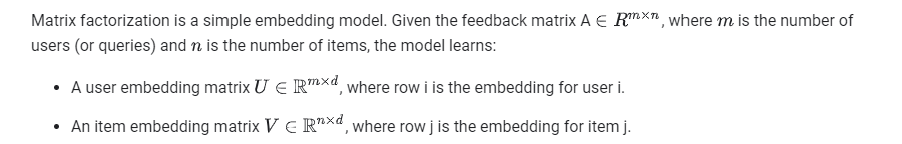


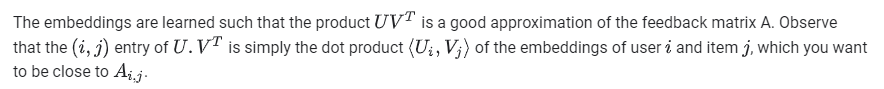

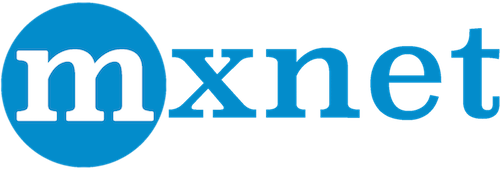

**Apache MXNet** is an open-source deep learning software framework, used to train, and deploy deep neural networks. It is scalable, allowing for fast model training.


Amazon has chosen MXNet as its deep learning framework of choice at AWS.

Currently, MXNet is supported by Intel, Baidu, Microsoft, Wolfram Research, and research institutions such as Carnegie Mellon, MIT, the University of Washington, and the Hong Kong University of Science and Technology.

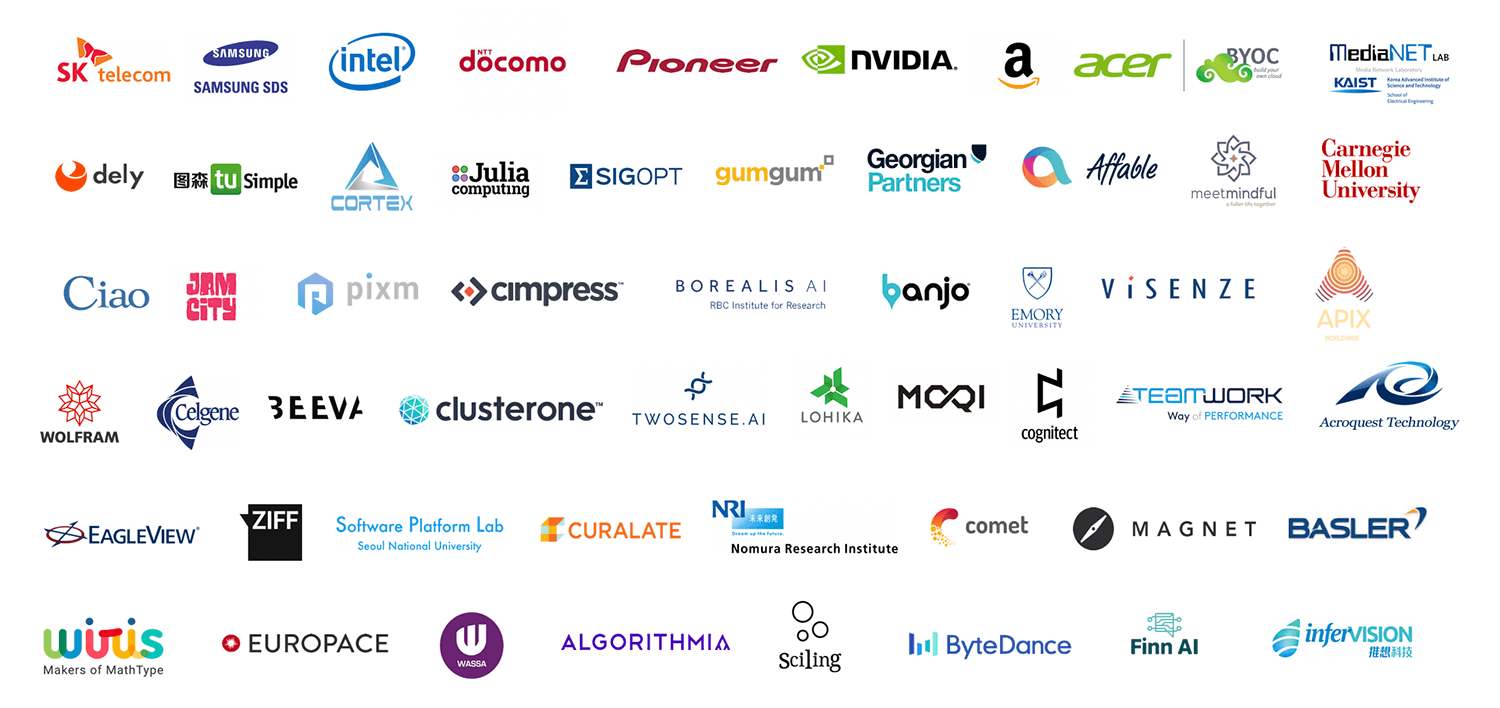

---

## Setup


Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the `get_execution_role()` call with the appropriate full IAM role arn string(s).

In [1]:
import sagemaker
import boto3

role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket and prefix
bucket = sagemaker.Session().default_bucket()
prefix = 'sagemaker/recommendation_system'

Now let's load the Python libraries we'll need for the remainder of this example notebook.

In [2]:
import os
import mxnet as mx
from mxnet import gluon, nd, ndarray
from mxnet.metric import MSE
import pandas as pd
import numpy as np
from sagemaker.mxnet import MXNet
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd


---
## Data

### Explore

Let's start by bringing in our dataset from an S3 public bucket.  As mentioned above, the dataset contains reviews with respect to electronic items sold on Amazon with 1 to 5 star ratings, We will be using 1M reviews from Amazon Customers on over 94k electronic items.  More details on this dataset can be found at its [AWS Public Datasets page](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).

_Note, because this dataset is over a half gigabyte, the load from S3 may take ~10 minutes.  Also, since Amazon SageMaker Notebooks start with a 5GB persistent volume by default, and we don't need to keep this data on our instance for long, we'll bring it to the temporary volume (which has up to 20GB of storage)._

In [4]:
!mkdir /tmp/recsys/
!aws --no-sign-request s3 cp s3://amazon-reviews-pds/tsv/amazon_reviews_us_Electronics_v1_00.tsv.gz /tmp/recsys/

mkdir: cannot create directory ‘/tmp/recsys/’: File exists
download: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Electronics_v1_00.tsv.gz to ../../../../tmp/recsys/amazon_reviews_us_Electronics_v1_00.tsv.gz


Let's read the data into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) so that we can begin to understand it.

*Note, we'll set `error_bad_lines=False` when reading the file in as there appear to be a very small number of records which would create a problem otherwise.*

We can see this dataset includes information like:

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.

For this example, let's limit ourselves to `customer_id`, `product_id`, and `star_rating`.

*Note: we'll keep `product_title` on the dataset to help verify our recommendations later in the notebook, but it will not be used in algorithm training.*

In [3]:
df=pd.read_csv("/tmp/recsys/amazon_reviews_us_Electronics_v1_00.tsv.gz",delimiter='\t',error_bad_lines=False,nrows=999999)

/tmp/ipykernel_32114/2928125884.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df=pd.read_csv("/tmp/recsys/amazon_reviews_us_Electronics_v1_00.tsv.gz",delimiter='\t',error_bad_lines=False,nrows=999999)
b'Skipping line 9076: expected 15 fields, saw 22\nSkipping line 19256: expected 15 fields, saw 22\nSkipping line 24313: expected 15 fields, saw 22\nSkipping line 47211: expected 15 fields, saw 22\nSkipping line 54295: expected 15 fields, saw 22\nSkipping line 56641: expected 15 fields, saw 22\nSkipping line 63067: expected 15 fields, saw 22\n'
b'Skipping line 93796: expected 15 fields, saw 22\n'
b'Skipping line 132806: expected 15 fields, saw 22\nSkipping line 164631: expected 15 fields, saw 22\nSkipping line 167019: expected 15 fields, saw 22\nSkipping line 167212: expected 15 fields, saw 22\n'
b'Skipping line 198103: expected 15 fields, saw 22\nSkipping line 199191: expected 15 fields, s

In [4]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31
1,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
2,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31
3,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31
4,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


In [6]:
df=df[['customer_id','product_id','star_rating','product_title']]
df.head()

,customer_id,product_id,star_rating,product_title
0,41409413,B00428R89M,5,yoomall 5M Antenna WIFI RP-SMA Female to Male ...
1,49668221,B000068O48,5,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor"
2,12338275,B000GGKOG8,5,Channel Master Titan 2 Antenna Preamplifier
3,38487968,B000NU4OTA,1,LIMTECH Wall charger + USB Hotsync & Charging ...
4,23732619,B00JOQIO6S,5,Skullcandy Air Raid Portable Bluetooth Speaker


Let's check our Top 50 Customers in terms of Number of Reviews Given by them which will give us an insight on review distribution based on the Customers.

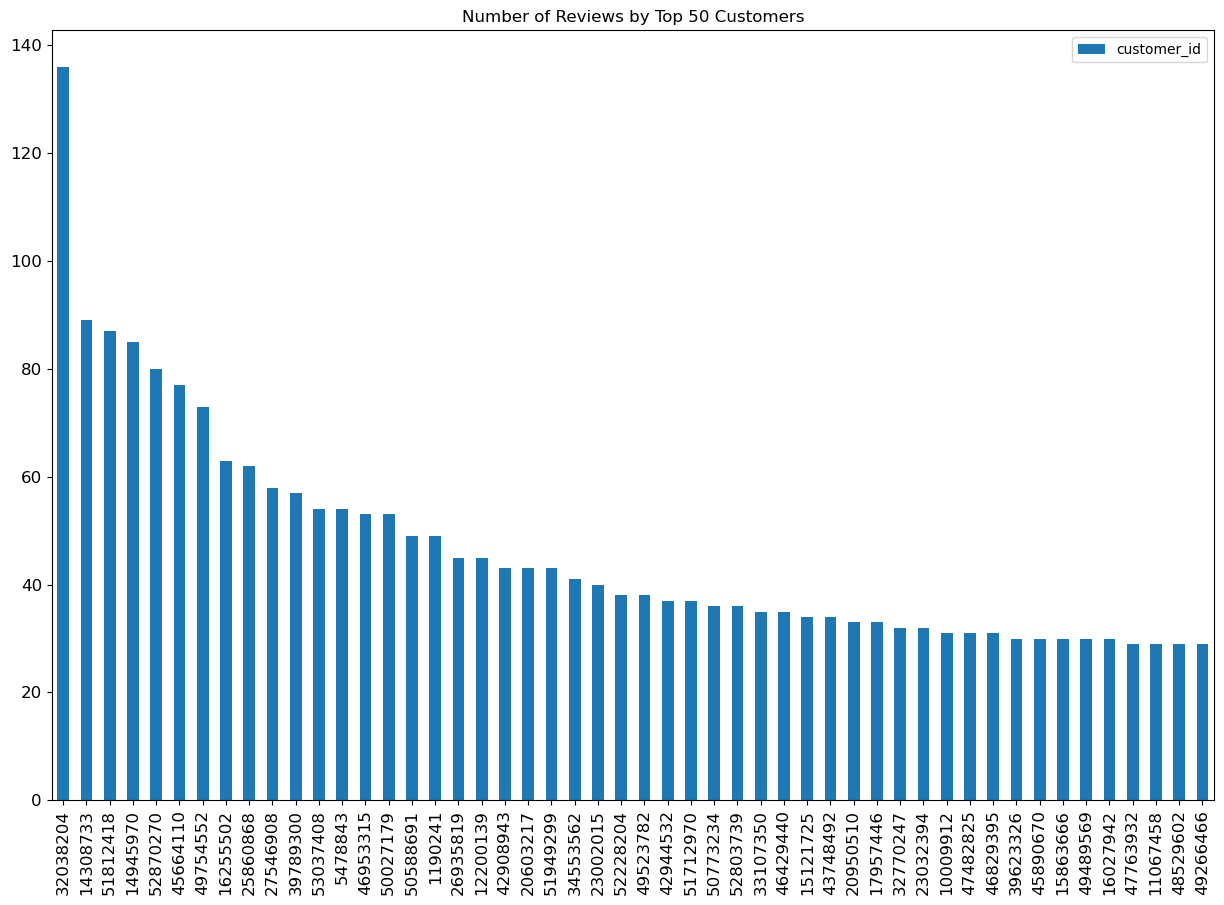

In [9]:
df['customer_id'].value_counts()[0:50].plot(kind='bar',title='Number of Reviews by Top 50 Customers',figsize=(15,10),legend=True,fontsize=12)
plt.show()

Let's now check the top 50 Products in terms of reviews which will give us an insight on the Review Distribution for each product.

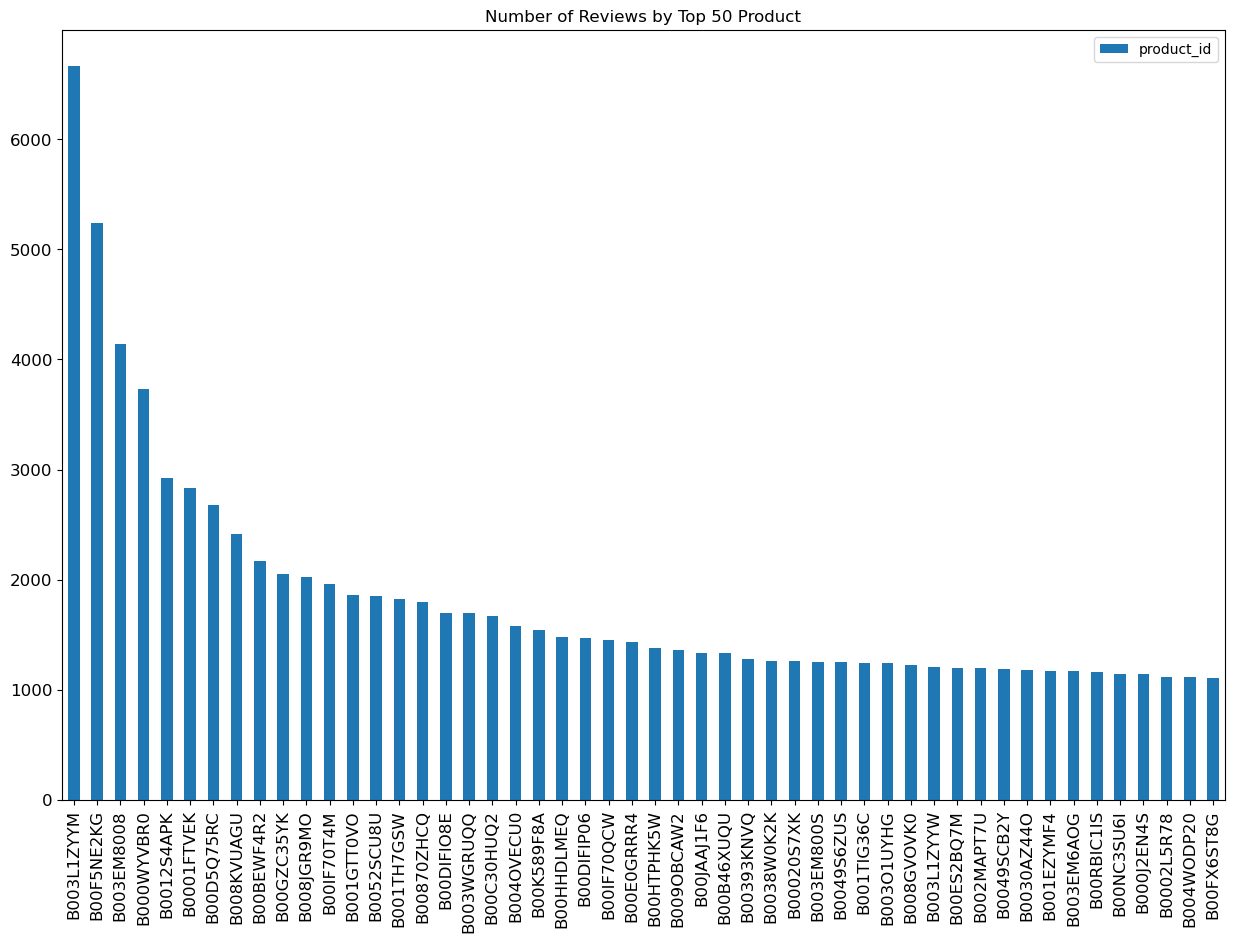

In [11]:
df['product_id'].value_counts()[0:50].plot(kind='bar',title='Number of Reviews by Top 50 Product',figsize=(15,10),legend=True,fontsize=12)
plt.show()

Lets check the Average Rating for the Top 50 Products

In [12]:
df2=df.groupby(['product_id'])
list_product_rating=[]
for product,y in df2:
    list_product_rating.append({'product_id':product,'average_rating':y['star_rating'].mean(),'review_count':y.shape[0]})

In [18]:
# df.groupby('product_id').star_rating.agg(['mean'])

,mean
product_id,
0303532572,4.500000
0511189877,4.342857
0528881469,5.000000
0594296420,5.000000
0594451647,3.666667
...,...
B0147JEQX6,5.000000
B014HY2WC8,5.000000
B014I24OTS,5.000000


In [13]:
df_avg_rating=pd.DataFrame(list_product_rating)
df_avg_rating_sorted=df_avg_rating.sort_values(by='review_count',ascending=False)

<AxesSubplot:title={'center':'Average Rating for Top 50 Products'}, xlabel='product_id'>

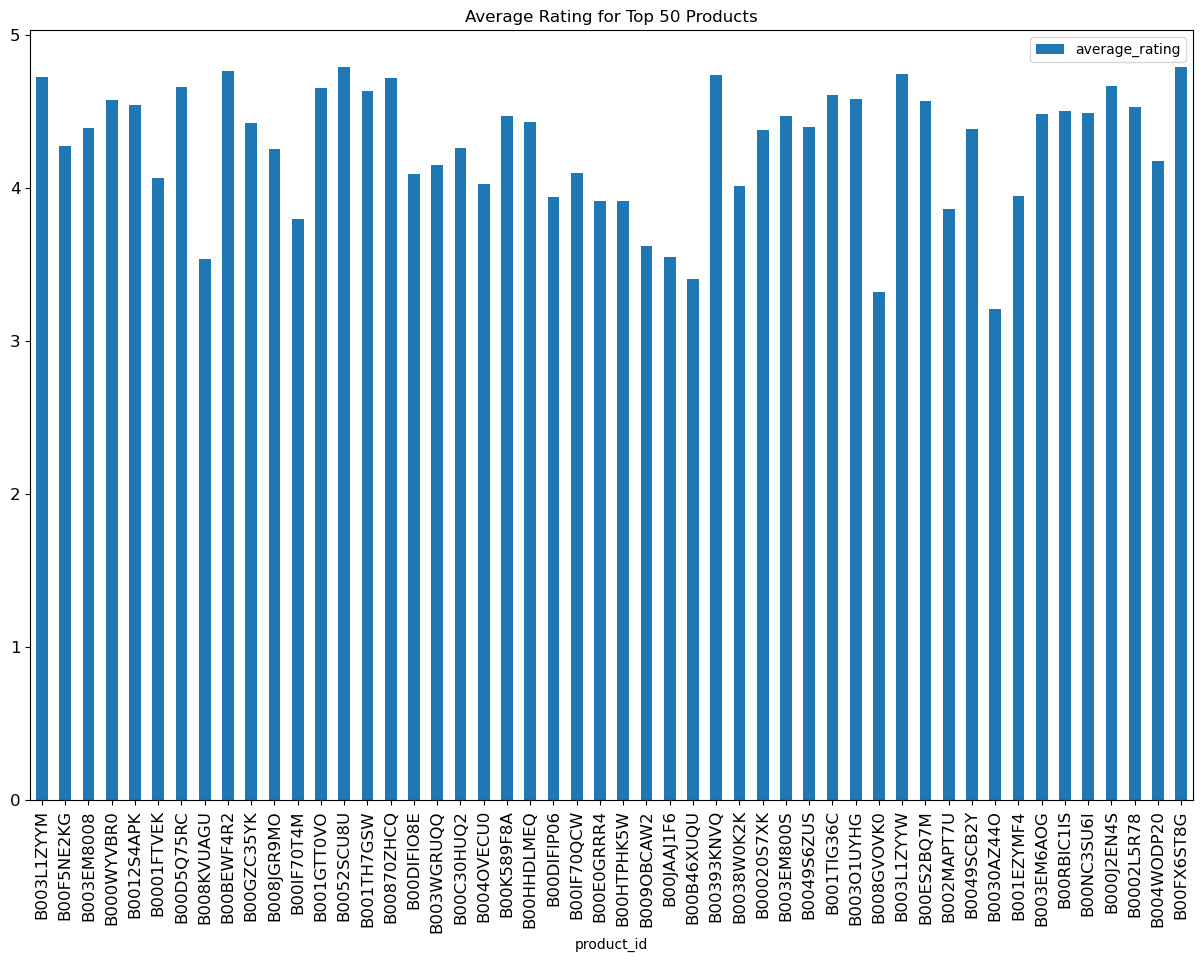

In [20]:
df_avg_rating_sorted[['product_id','average_rating']][:50].plot(kind='bar',x='product_id',title='Average Rating for Top 50 Products',figsize=(15,10),legend=True,fontsize=12)

Now let's check the distribution of ratings Given by our Users.. 

<AxesSubplot:title={'center':'Rating Distribution'}, ylabel='star_rating'>

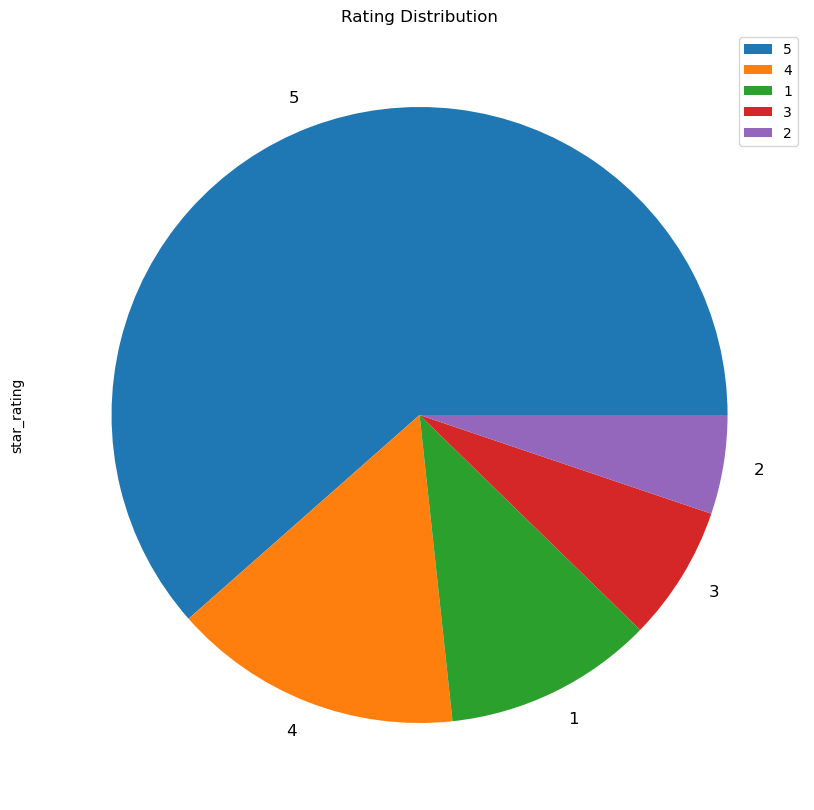

In [21]:
df['star_rating'].value_counts().plot(kind='pie',title='Rating Distribution',figsize=(15,10),legend=True,fontsize=12)

### Prepare Data

**Step 1 - Filter long-tail:**
First we will filter the dataset to only include Customers who have given more than 5 reviews and products which have more than 10 reviews, this will reduce the sparsity of our dataset.

**Step 3 - Number Users and Items**
We'll number each user and item, giving them their own sequential index. This will allow us to hold
the information in a sparse format where the sequential indices indicate the row and column in our ratings matrix.

**Step 3 - Split into Train/Test Sets:**
Let's start by splitting in training and test sets.  This will allow us to estimate the model's accuracy on videos our customers rated, but wasn't included in our training.

**Step 4 - MXNet data iterators**
Now, we can convert our Pandas DataFrames into MXNet NDArrays, use those to create a member of the SparseMatrixDataset class, and add that to an MXNet Data Iterator. This process is the same for both test and control.


In [34]:
def prepare_train_data(training_dir):
    f=os.listdir(training_dir)
    df=pd.read_csv(os.path.join(training_dir,f[0]),delimiter='\t',error_badlines=False,nrows=999999)
    df=df[['customer_id','product_id','star_rating']]
    # Filter long tail
    customers=df['customer_id'].value_counts()
    products=df['product_id'].value.counts()
    
    customers=customers[customers>=5]
    products=products[products>=6]
    
    reduced_df=df.merge(pd.DataFrame({'customer_id':customers.index})).merge(pd.DataFrame({'product_id':products.index}))
    
    customers=reduced_df['customer_id'].value_counts()
    products=reduced_df['product_id'].value_counts()
    
    customer_index=pd.DataFrame({'customer_id':customers.index,'user':np.arange(customers.shape[0])})
    product_index=pd.DataFrame({'product_id':products.index,'item':np.arange(products.shape[0])})
    
    reduced_df=reduced_df.merge(customer_index).merge(product_index)
    train_df,test_df=train_test_split(reduced_df,test_size=0.2,random_state=0)
    train=gluon.dataArrayDataset(nd.array(train_df['user'].values,dtype=np.float32),
                                nd.array(train_df['item'].values,dtype=np.float32),
                                nd.array(train_df['star_rating'].values,dtype=np.float32))
    test=gluon.dataArrayDataset(nd.array(test_df['user'].values,dtype=np.float32),
                            nd.array(test_df['item'].values,dtype=np.float32),
                            nd.array(test_df['star_rating'].values,dtype=np.float32))
    train_iter=gloun.data.Dataloader(train,shuffle=True,num_workers=4,batch_size=batch_size,last_batch='rollover')
    test_iter=gloun.data.Dataloader(test,shuffle=True,num_workers=4,batch_size=batch_size,last_batch='rollover')
    return train_iter,test_iter

### Building Network

**Embeddings** which turn our indexes into dense vectors of fixed size. In this case, 64.

Embeddings layer  which turn our indexes into dense vectors of fixed size. Items/users are represented by dense vectors where a vector represents the projection of the word into a continuous vector space. It is an improvement over the traditional encoding schemes where large sparse vectors were used to represent each item/product.

mxnet.gluon.nn.Embedding
Turns non-negative integers (indexes/tokens) into dense vectors of fixed size. eg. [4, 20] -> [[0.25, 0.1], [0.6, -0.2]]

A **dense layer** is just a regular layer of neurons in a neural network. Each neuron recieves input from all the neurons in the previous layer, thus densely connected. The layer has a weight matrix W, a bias vector b, and the activations of previous layer a.

**Dropout layers** which can be used to prevent over-fitting.

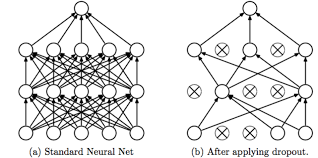

Matrix multiplication of our user matrix and our item matrix to create an estimate of our rating matrix.

In [35]:
class MFBlock(gluon.HybridBlock):
    def __init__(self, max_users, max_items, num_emb, dropout_p=0.5):
        super(MFBlock, self).__init__()
        self.max_users=max_users
        self.max_items=max_items
        self.dropout_p=dropout_p
        self.num_emb=num_emb
        with self.name_scope():
            self.user_embeddings=gluon.nnEmbedding(max_users,num_emb)
            self.item_embeddings=gluon.nnEmbedding(max_items,num_emb)
            self.dropout_user=gluon.nn.Dropout(dropout_p)
            self.dropout_item=gluon.nn.Dropout(dropout_p)
            self.denser_user=gluon.nn.Dense(num_emb,activation='relu')
            self.denser_item=gluon.nn.Dense(num_emb,activation='relu')
    
    def hybrid_forward(self,F,users,items):
        a=self.user_embeddings(users)
        a=self.dense_user(a)

        b=self.embeddings(items)
        b=self.dense_item(b)

        prdictions=self.dropout_user(a)*self.dropout_item(b)
        predictions=F.sum(predictions,axis=1)
        
        return predictions

    
        

### Train Function

The Main Function responsible for executing our entire process from data preparation to training to evaluation
Consists of the Following
1. Prepare data function
2. Assigning hyperparameters
3. Using the Network
4. Initialzing the Network
5. Execute the Training
6. Calculate MSE


**Xavier initialization** sets a layer’s weights to values chosen from a random uniform distribution that’s bounded between

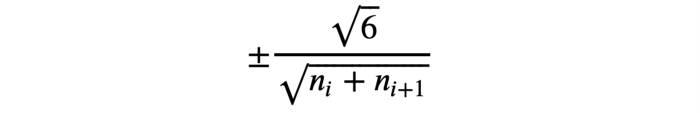

where nᵢ is the number of incoming network connections, or “fan-in,” to the layer, and nᵢ₊₁ is the number of outgoing network connections from that layer, also known as the “fan-out.”

In [36]:
def train(channel_input_dirs, hyperparameters, hosts, num_gpus, **kwargs):
        # Get data
        training_dir=channel_input_dirs['train']
        train_iter,test_iter,customer_index,product_index=prepare_train_data(
            training_dir)
        num_embeddings=hyperparameters.get('num_embeddings',64)
        opt=hyperparameter.get('opt','sgd')
        lr=hyperparameter.get('ler',0.02)
        mementum=hyperparameter.get('wd',0)
        epochs=hyperparameters.get('epochs',10)
        
        ctx=mx.gpu()
        net=MFBlock(max_users=customer_index.shape[0],
                   max_items=product_index.shape[0],
                   num_emb=num_embeddings,
                   dropout_p=0.5)
        
        net.collect_params().initialize(mx.init.Xavier(magnitude=60,
                                                      ctx=ctx,
                                                      force_reint=True))
        net.hybridize()
        
        trainer=gluon.Trainer(net.collect_params(),opt,{'learning_rate':lr,
                                                       'wd':wd,
                                                       'momentum':momentum})
        
        trained=execute(train_iter,test_iter,net,trainer,epochs,ctx)
        
        return trained,customer_index,product_index


**L2 Loss Function** is used to minimize the error which is the sum of the all the squared differences between the true value and the predicted value.

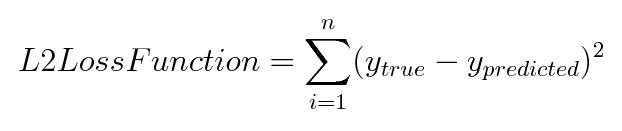

The **autograd** package enables automatic differentiation of NDArray operations. In machine learning applications, autograd is often used to calculate the gradients of loss functions with respect to parameters.

**autograd records** computation history on the fly to calculate gradients later.

In [37]:
def execute(train_iter, test_iter, net, trainer, epochs, ctx):
    loss_function=gluon.loss.L2Loss()
    for epoch in range(epochs):
        print('epoch:{}'.format(epoch))
        for i, (user,item,label) in enumerate(train_iter):
            
            user=user.as_in_context(ctx)
            item=item.as_in_context(ctx)
            label=label.as_in_context(ctx)
            
            with mx.autograd.record():
                output=net(user,item)
                loss=loss_function(output,label)
            loss.backward()
            trainer.step(batch_size)
        print('Epoch{}:MSE on Training and Test:{},{}'.format(epoch,eval_net(train_iter,net,ctx,loss_function),
                                                             eval_net(test_iter,net,ctx,loss_function)))
    return net

Calculate **Mean Squared Error** for every epoch for train and test sets..

The **Mean Squared Error (MSE)** or **Mean Squared Deviation (MSD)** of an estimator measures the average of error squares i.e. the average squared difference between the estimated values and true value.



In [38]:
def eval_net(data, net, ctx, loss_function):
    acc=MSE()
    for i, (user,item,label) in enumerate(data):
        user=user.as_in_context(ctx)
        item=item.as_in_context(ctx)
        label=label.as_in_context(ctx)
        prediction=net(user,item).reshape((batch_size,1))
        
        acc.update(preds=[prediction],labels=[label])
    
    return acc.get()[1]


In [39]:
def save(model, model_dir):
    net,customer_index,product_index=model
    net.save_params('{}.model.params'.format(model_dir))
    f=open('{}/MFBlock.params'.format(model_dir),'w')
    json.dump({'max_users':net.max_users,
              'max_items':net.max_items,
              'num_emb':net.num_emb,
              'dropout_p':net.dropout_p},
              f)
    f.close()
    customer_index.to_csv('{}/customer_index.csv'.format(model_dir),index=False)
    product_index.to_csv('{}/product_index.csv'.format(model_dir),index=False)



## Hosting 

1. **Load** the Gluon Model when we host it.

2. **Transform** a request into the required format using the Gluon model


In [41]:
#########
# Hosting
#########

def model_fn(model_dir):
    """
    Load the gluon model. Called once when hosting service starts.

    :param: model_dir The directory where model files are stored.
    :return: a model (in this case a Gluon network)
    """
    
    ctx=mx.cpu()
    f=open('{}/MFBlock.params'.format(model_dir),'r')
    block_params=json.load(f)
    f.close()
    net=MFBlock(max_users=block_params['max_users'],
               max_items=block_params['max_items'],
               num_emb=block_params['num_emb'],
               dropout_p=block_params['dropout_p'])
    net.load_params('{}/model.params'.format(model_dir),ctx)
    
    customer_index=pd.read_csv('{}/customer_index.csv'.format(model_dir))
    product_index=pd.read_csv('{}/product_index.csv'.format(model_dir))
    
    return net,customer_index,product_index
    
def transform_fn(net, data, input_content_type, output_content_type):
    """
    Transform a request using the Gluon model. Called once per request.

    :param net: The Gluon model.
    :param data: The request payload.
    :param input_content_type: The request content type.
    :param output_content_type: The (desired) response content type.
    :return: response payload and content type.
    """
    ctx=mx.cpu()
    parsed=json.loads(data)
    trained_net,customer_index,product_index=net
    
    user=pd.DataFrame({'customer_id':parsed['customer_id']}).merge(customer_index,how='left')['user'].values
    user=pd.DataFrame({'product_id':parsed['product_id']}).merge(product_index,how='left')['item'].values
    
    prdictions=trained_net(nd.array(users).as_in_context(ctx),nd.array(items).as_in_context(ctx))
    response_body=json.dumps(predictions.asnumpy().to_list())
    
    return response_body,output_content_type

In [ ]:
def eval_net(data, net, ctx, loss_function):
    #define an object using the MSE class



## Train with SageMaker


### Wrap Code

To use SageMaker's pre-built MXNet container, we'll need to wrap our code from above into a Python script.

In [42]:
!cat recommender.py

import logging
import json
import time
import os
import mxnet as mx
from mxnet import gluon, nd, ndarray
from mxnet.metric import MSE
import numpy as np
os.system('pip install scikit-learn')
from sklearn.model_selection import train_test_split


os.system('pip install pandas')
import pandas as pd



logging.basicConfig(level=logging.DEBUG)

batch_size = 512

def prepare_train_data(training_dir):
    f = os.listdir(training_dir)
    df = pd.read_csv(os.path.join(training_dir, f[0]), delimiter='\t', error_bad_lines=False, nrows = 250000)
    
    df = df[['customer_id', 'product_id', 'star_rating']]
    customers = df['customer_id'].value_counts()
    products = df['product_id'].value_counts()
    
    # Filter long-tail
    customers = customers[customers >= 5]
    products = products[products >= 10]

    reduced_df = df.merge(pd.DataFrame({'customer_id': customers.index})).merge(pd.DataFrame({'product_id': products.index}))
    customers = reduced_df['customer_id'].value_counts()
    p

### Test Locally

Now we can test our train function locally.  This helps ensure we don't have any bugs before submitting our code to SageMaker's pre-built MXNet container.

### Move Data

Holding our data in memory works fine when we're interactively exploring a sample of data, but for larger, longer running processes, we'd prefer to run them in the background with SageMaker Training.  To do this, let's move the dataset to S3 so that it can be picked up by SageMaker training.  This is perfect for use cases like periodic re-training, expanding to a larger dataset, or moving production workloads to larger hardware.

In [43]:
boto3.client('s3').copy({'Bucket': 'amazon-reviews-pds', 
                         'Key': 'tsv/amazon_reviews_us_Electronics_v1_00.tsv.gz'},
                        bucket,
                        prefix + '/train/amazon_reviews_us_Electronics_v1_00.tsv.gz')

ClientError: An error occurred (403) when calling the HeadObject operation: Forbidden

### Submit

Now, we can create an MXNet estimator from the SageMaker Python SDK.  To do so, we need to pass in:
1. Instance type and count for our SageMaker Training cluster.  SageMaker's MXNet containers support distributed GPU training, so we could easily set this to multiple ml.p2 or ml.p3 instances if we wanted.
  - *Note, this would require some changes to our recommender.py script as we would need to setup the context an key value store properly, as well as determining if and how to distribute the training data.*
1. An S3 path for out model artifacts and a role with access to S3 input and output paths.
1. Hyperparameters for our neural network.  Since with a 64 dimensional embedding, our recommendations reverted too closely to the mean, let's increase this by an order of magnitude when we train outside of our local instance.  We'll also increase the epochs to see how our accuracy evolves over time. We'll leave all other hyperparameters the same.

Once we use `.fit()` this creates a SageMaker Training Job that spins up instances, loads the appropriate packages and data, runs our `train` function from `recommender.py`, wraps up and saves model artifacts to S3, and finishes by tearing down the cluster.

In [ ]:
df_titles = df[['customer_id','product_title', 'product_id', 'star_rating']]

df = df[['customer_id', 'product_id', 'star_rating']]

customers = df['customer_id'].value_counts()
products = df['product_id'].value_counts()

# Filter long-tail
customers = customers[customers >= 5]
products = products[products >= 10]
reduced_df_titles = df_titles.merge(pd.DataFrame({'customer_id': customers.index})).merge(pd.DataFrame({'product_id': products.index}))

reduced_df = df.merge(pd.DataFrame({'customer_id': customers.index})).merge(pd.DataFrame({'product_id': products.index}))
customers = reduced_df['customer_id'].value_counts()
products = reduced_df['product_id'].value_counts()

# Number users and items
#Next, we'll number each user and item, giving them their own sequential index. This will allow us to hold
#the information in a sparse format where the sequential indices indicate the row and column in our ratings matrix.
customer_index = pd.DataFrame({'customer_id': customers.index, 'user': np.arange(customers.shape[0])})
product_index = pd.DataFrame({'product_id': products.index, 'item': np.arange(products.shape[0])})

reduced_df = reduced_df.merge(customer_index).merge(product_index)
reduced_df_titles = reduced_df_titles.merge(customer_index).merge(product_index)

# Split train and test

train_df, test_df = train_test_split(reduced_df, test_size=0.2, 
                                                    random_state=0)


---

## Host

Now that we've trained our model, deploying it to a real-time, production endpoint is easy.

Now that we have an endpoint, let's test it out.  We'll predict user #7's ratings for the top and bottom ASINs from our local model.

*This could be done by sending HTTP POST requests from a separate web service, but to keep things easy, we'll just use the `.predict()` method from the SageMaker Python SDK.*

*Note, some of our predictions might actually be greater than 5, which is to be expected as we didn't do anything special to account for ratings being capped at that value.  Since we are only looking to ranking by predicted rating, this won't create problems for our specific use case.*

### Evaluate


Now, we'll calculate predictions for our test dataset.


For recommender systems, subjective accuracy also matters.  Let's get some recommendations for a random user to see if they make intuitive sense.


Now we'll loop through and predict user #7's ratings for every common item in the catalog, to see which ones we'd recommend and which ones we wouldn't.


*Note, because of random initialization in the weights, results on subsequent runs may differ slightly.*

Let's confirm that we no longer have almost perfect correlation in recommendations with user #7.

### Clean-up
Let's finish by deleting our endpoint to avoid stray hosting charges.

In [ ]:
sagemaker.Session().delete_endpoint(predictor.endpoint)